In [9]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [10]:
def cramers(df):
    num_cols = df.shape[1]
    cramer_matrix = np.zeros((num_cols, num_cols))
    for cat1 in range(num_cols):
        for cat2 in range(num_cols):
            ct = pd.crosstab(df[df.columns[cat1]], df[df.columns[cat2]])
            c, p, dof, expected = chi2_contingency(ct)
            n = sum(np.sum(ct))
            k = min(ct.shape)
            cramer_matrix[cat1, cat2] = math.sqrt(c / (n * k))
    cramer_matrix = pd.DataFrame(
        cramer_matrix, columns=df.columns, index=df.columns)
    return cramer_matrix

In [11]:
def visualize_data(selected_features_df):

    plt.hist(selected_features_df['Age'], bins=10, edgecolor='k', alpha=1.0)
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

    plt.hist(selected_features_df['Previous Purchases'],
             bins=10, edgecolor='k', alpha=1.0)
    plt.xlabel('Previous Purchases')
    plt.ylabel('Count')
    plt.show()

    plt.figure()
    sns.heatmap(selected_features_df.select_dtypes(
        include=['int', 'float']).corr(), vmin=-1, vmax=1, annot=True)
    plt.title('Correlation Matrix')
    plt.show()

    cat_var = selected_features_df.select_dtypes('object')
    sns.heatmap(cramers(cat_var), vmin=0, vmax=1, annot=True)

In [12]:
def visualize_data(selected_features_df):

    plt.hist(selected_features_df['Age'], bins=10, edgecolor='k', alpha=1.0)
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

    plt.hist(selected_features_df['Previous Purchases'],
             bins=10, edgecolor='k', alpha=1.0)
    plt.xlabel('Previous Purchases')
    plt.ylabel('Count')
    plt.show()

    plt.figure()
    sns.heatmap(selected_features_df.select_dtypes(
        include=['int', 'float']).corr(), vmin=-1, vmax=1, annot=True)
    plt.title('Correlation Matrix')
    plt.show()

    cat_var = selected_features_df.select_dtypes('object')
    sns.heatmap(cramers(cat_var), vmin=0, vmax=1, annot=True)


def preprocess_data(selected_features_df):
    sc = StandardScaler()
    scaled_df = pd.concat([selected_features_df["Age"],
                           selected_features_df["Previous Purchases"]], axis=1)
    sc.fit(scaled_df)
    scaled_df = sc.transform(scaled_df)
    scaled_df = pd.DataFrame(scaled_df, columns=["Age", "Previous Purchases"])
    scaled_df = pd.concat([scaled_df, selected_features_df['Gender'], selected_features_df['Location'], selected_features_df['Season'],
                           selected_features_df['Subscription Status'], selected_features_df['Frequency of Purchases']], axis=1)

    gender = pd.get_dummies(
        selected_features_df['Gender'], drop_first=True, dtype=int)
    loc = pd.get_dummies(
        selected_features_df['Location'], drop_first=True, dtype=int)
    season = pd.get_dummies(
        selected_features_df['Season'], drop_first=True, dtype=int)
    status = pd.get_dummies(
        selected_features_df['Subscription Status'], drop_first=True, dtype=int)
    freq = pd.get_dummies(
        selected_features_df['Frequency of Purchases'], drop_first=True, dtype=int)

    encoded_and_scaled_df = scaled_df
    encoded_and_scaled_df = pd.concat(
        [scaled_df, gender, loc, season, status, freq], axis=1)
    encoded_and_scaled_df.drop(columns=['Gender', 'Location', 'Season',
                                        'Subscription Status', 'Frequency of Purchases'], inplace=True)

    pca = PCA(n_components=3)
    pca.fit(encoded_and_scaled_df)
    pca_df = pd.DataFrame(pca.transform(encoded_and_scaled_df),
                          columns=['PC1', 'PC2', 'PC3'])

    return pca_df, encoded_and_scaled_df, sc, pca


In [13]:
def train_model(pca_df):
    num_clusters = int(input(
        'Enter the number of clusters you want to segment users into based on their demographics. This must be more than the number of recommendations you want.'))
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    kmeans.fit(pca_df)
    labels = kmeans.predict(pca_df)

    return labels, kmeans

In [14]:
def get_customer_cluster(encoded_and_scaled_df, sc, pca, kmeans):
    age = int(
        input('Enter the age of an existing customer you want recommendations for'))
    gender = input('Enter the gender of the customer')
    location = input('Enter the US State the customer resides in')
    season = input('Enter the season the customer is making a purchase during')
    subscription_status = input('Provide the subscription status of the user')
    previous_purchases = int(
        input('Enter the number of purchases the customer the customer has made'))
    frequency_of_purchases = input(
        'Enter the frequency at which the customer makes purchases')
    row = [age, gender, location, season, subscription_status,
           previous_purchases, frequency_of_purchases]
    sample = pd.DataFrame([row], columns=['Age', 'Gender', 'Location', 'Season',
                                          'Subscription Status', 'Previous Purchases', 'Frequency of Purchases'])

    scaled_sample = pd.DataFrame(sc.transform(
        sample[['Age', 'Previous Purchases']]), columns=['Age', 'Previous Purchases'])
    scaled_sample = pd.DataFrame(scaled_sample, columns=[
        "Age", "Previous Purchases"])
    scaled_sample = pd.concat([scaled_sample, sample['Gender'], sample['Location'], sample['Season'],
                               sample['Subscription Status'], sample['Frequency of Purchases']], axis=1)

    bin_cols = list(encoded_and_scaled_df.columns)
    bin_cols = bin_cols[2:len(bin_cols)]
    encoded_and_scaled_sample = scaled_sample
    for col in bin_cols:
        if encoded_and_scaled_sample['Gender'][0] in col or encoded_and_scaled_sample['Location'][0] in col or encoded_and_scaled_sample['Season'][0] in col or encoded_and_scaled_sample['Subscription Status'][0] in col or encoded_and_scaled_sample['Frequency of Purchases'][0] in col:
            new_col = pd.DataFrame([1], columns=[col])
        else:
            new_col = pd.DataFrame([0], columns=[col])
        encoded_and_scaled_sample = pd.concat(
            [encoded_and_scaled_sample, new_col], axis=1)
    encoded_and_scaled_sample.drop(columns=[
        'Gender', 'Location', 'Season', 'Subscription Status', 'Frequency of Purchases'], inplace=True)

    pca_sample = pd.DataFrame(pca.transform(
        encoded_and_scaled_sample), columns=['PC1', 'PC2', 'PC3'])

    [cluster] = kmeans.predict(pca_sample)

    return cluster, sample

In [15]:
def get_customer_recommendations(df, cluster):
    similar_customers = df.loc[df["Clusters"] == cluster]
    potential_recommendations = similar_customers[df['Review Rating'] >= 3]

    items = potential_recommendations['Item Purchased'].value_counts()

    num_recs = int(
        input('Enter the number of recommendations you want for the customer'))
    print("Here are your top", num_recs,
          "recommendations based on what similar customers have been satisifed with!")
    for i in range(num_recs):
        print(items.index[i])


def visualize_customer_cluster(df, cluster, sample):
    for index in df.index:
        if df.loc[index, 'Clusters'] == cluster:
            df.loc[index, 'Colors'] = 'orange'
        else:
            df.loc[index, 'Colors'] = 'blue'

    var_names = [('Age', sample['Age'][0]), ('Gender', sample['Gender'][0]), ('Location', sample['Location'][0]), ('Season', sample['Season'][0]), ('Subscription Status',
                                                                                                                                                    sample['Subscription Status'][0]), ('Previous Purchases', sample['Previous Purchases'][0]), ('Frequency of Purchases', sample['Frequency of Purchases'][0])]

    feature_one = input('Enter the first feature you want to plot')
    feature_two = input('Enter the second feature you want to plot')

    features_to_plot = []

    for tuple in var_names:
        if tuple[0] == feature_one or tuple[0] == feature_two:
            features_to_plot.append(tuple[1])

    plt.scatter(df[feature_one], df[feature_two], c=df['Colors'])

    sample_feature_one = features_to_plot[0]
    sample_feature_two = features_to_plot[1]

    plt.scatter(sample_feature_one, sample_feature_two, c='red', s=100)
    plt.xlabel(feature_one)
    plt.ylabel(feature_two)
    plt.show()


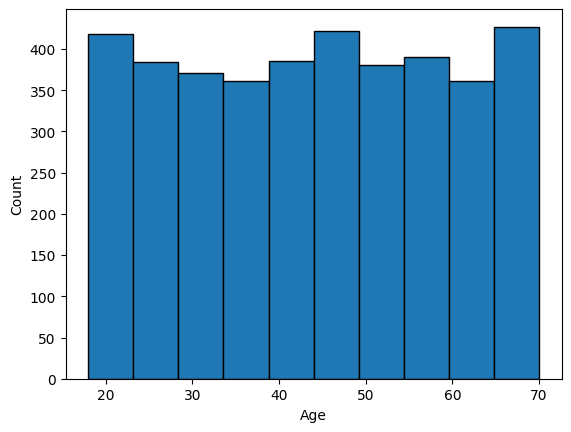

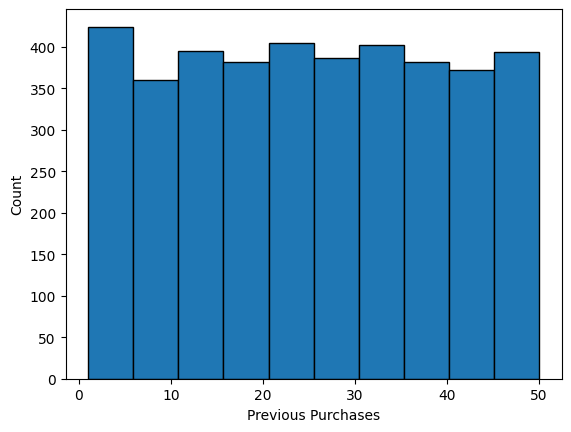

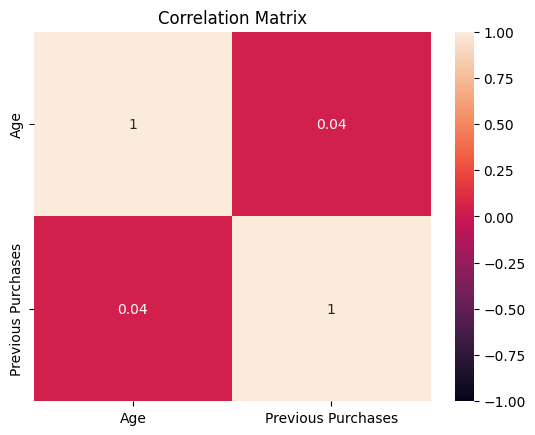

/var/folders/5l/7bmxvb2x6sq3y8958yv03lq40000gn/T/ipykernel_71535/429692870.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  potential_recommendations = similar_customers[df['Review Rating'] >= 3]


Here are your top 5 recommendations based on what similar customers have been satisifed with!
Blouse
Shirt
Skirt
Pants
Belt


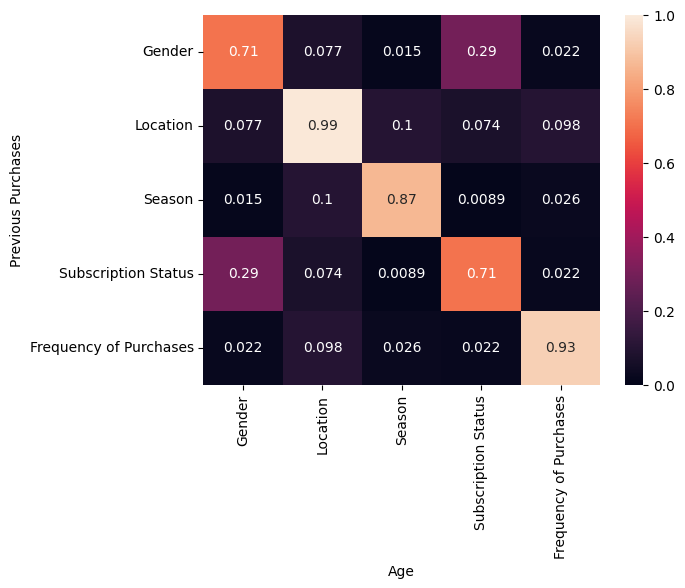

In [16]:
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv(
    "/Users/suyashgoel/product-recommendation/shopping_behavior_updated.csv")
selected_features_df = df[['Age', 'Gender', 'Location', 'Season',
                           'Subscription Status', 'Previous Purchases', 'Frequency of Purchases']]
visualize_data(selected_features_df)
pca_df, encoded_and_scaled_df, sc, pca = preprocess_data(
    selected_features_df)
labels, kmeans = train_model(pca_df)

df["Clusters"] = labels

cluster, sample = get_customer_cluster(
    encoded_and_scaled_df, sc, pca, kmeans)

df.loc[df['Clusters'] == cluster]

get_customer_recommendations(df, cluster)
visualize_customer_cluster(df, cluster, sample)